In [1]:
import pandas as pd
import itertools

# Load dataset and sample 100 rows with valid labels
df = pd.read_csv("test.csv")
df = df[df["label"].notnull()].sample(n=100, random_state=42)

In [2]:
# Parameter grid
temperatures = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
max_tokens_list = [20, 30, 40, 50]
styles = ["fewshot", "cot"]

param_grid = list(itertools.product(temperatures, max_tokens_list, styles))

In [3]:
def build_prompt(question, correct_answer, response, style="fewshot"):
    if style == "fewshot":
        prompt = f"""
                    You are grading a short answer exam.
                    
                    Examples:
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: they can be unethical
                    Label: 1
                    
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: Harmful effects towards those being expeiremneted on
                    Label: 0
                    
                    Question: Name one potential disadvantage of experiments
                    CorrectAnswer: Unethical, not interested in causality, expensive, or difficult to run
                    Response: They can be biased or unbiased
                    Label: -1
                    
                    Now grade this:
                    Question: {question}
                    CorrectAnswer: {correct_answer}
                    Response: {response}

                    Your answer (only -1, 0, or 1):
                """
    elif style == "cot":
        prompt = f"""
                    You are a short answer grader. Think step-by-step.
                    
                    1. Analyze if the Response matches the key information in the CorrectAnswer.
                    2. Decide:
                        - If correct, output 1.
                        - If similar but not exact, output 0.
                        - If wrong, output -1.
                    
                    Question: {question}
                    CorrectAnswer: {correct_answer}
                    Response: {response}
                    
                    Your analysis and final Label (only -1, 0, or 1):
                """
    return prompt

In [14]:
import openai
import os
from sklearn.metrics import classification_report
import time
from openai import OpenAI
from dotenv import load_dotenv, dotenv_values

In [15]:
config = dotenv_values(".env")
openai_client = OpenAI(api_key=config["OPENAI_API_KEY"])

In [16]:
# Helper to parse final label
def parse_prediction(resp):
    try:
        resp = resp.strip()
        for token in reversed(resp.split()):
            if token in {"-1", "0", "1"}:
                return int(token)
        return None
    except:
        return None

In [18]:
# Run test
results = []

for temp, max_tok, style in param_grid:
    preds = []
    for _, row in df.iterrows():
        prompt = build_prompt(row["Question"], row["CorrectAnswer"], row["Response"], style)
        try:
            response = openai_client.chat.completions.create(
                model="gpt-3.5-turbo-1106",
                messages=[
                    {"role": "system", "content": "You are a strict short answer grader. Output ONLY -1, 0, or 1."},
                    {"role": "user", "content": prompt}
                ],
                temperature=temp,
                max_tokens=max_tok
            )
            pred = parse_prediction(response.choices[0].message.content.strip())
        except Exception as e:
            print("Error:", e)
            pred = None
        preds.append(pred)
        time.sleep(1.2)

    y_true = df["label"].astype(int).reset_index(drop=True)
    y_pred = pd.Series(preds)
    mask = y_pred.notnull()
    metrics = classification_report(y_true[mask], y_pred[mask], output_dict=True, zero_division=0)

    results.append({
        "temperature": temp,
        "max_tokens": max_tok,
        "style": style,
        "precision": metrics["macro avg"]["precision"],
        "recall": metrics["macro avg"]["recall"],
        "f1": metrics["macro avg"]["f1-score"],
        "samples": mask.sum()
    })

results_df = pd.DataFrame(results)
results_df.sort_values("f1", ascending=False, inplace=True)

In [ ]:
print(results_df)

# Save for later
results_df.to_csv("test_param_100", index=False)

    temperature  max_tokens    style  precision    recall        f1  samples
46          0.5          50  fewshot   0.610256  0.559831  0.573973      100
28          0.3          40  fewshot   0.610256  0.559831  0.573973      100
26          0.3          30  fewshot   0.610256  0.552079  0.568519      100
34          0.4          30  fewshot   0.598039  0.559831  0.566656      100
32          0.4          20  fewshot   0.606061  0.552079  0.566039      100
0           0.0          20  fewshot   0.599034  0.558140  0.564217      100
16          0.2          20  fewshot   0.606965  0.550388  0.563457      100
4           0.0          40  fewshot   0.598039  0.552079  0.561201      100
10          0.1          30  fewshot   0.598039  0.552079  0.561201      100
18          0.2          30  fewshot   0.598039  0.552079  0.561201      100
38          0.4          50  fewshot   0.606061  0.544327  0.560431      100
44          0.5          40  fewshot   0.609375  0.538266  0.559830      100

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

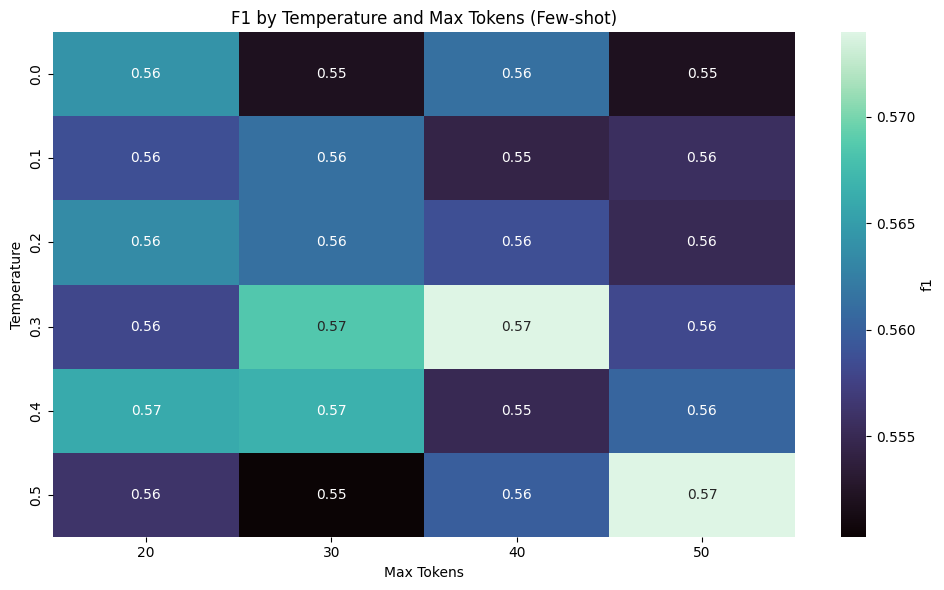

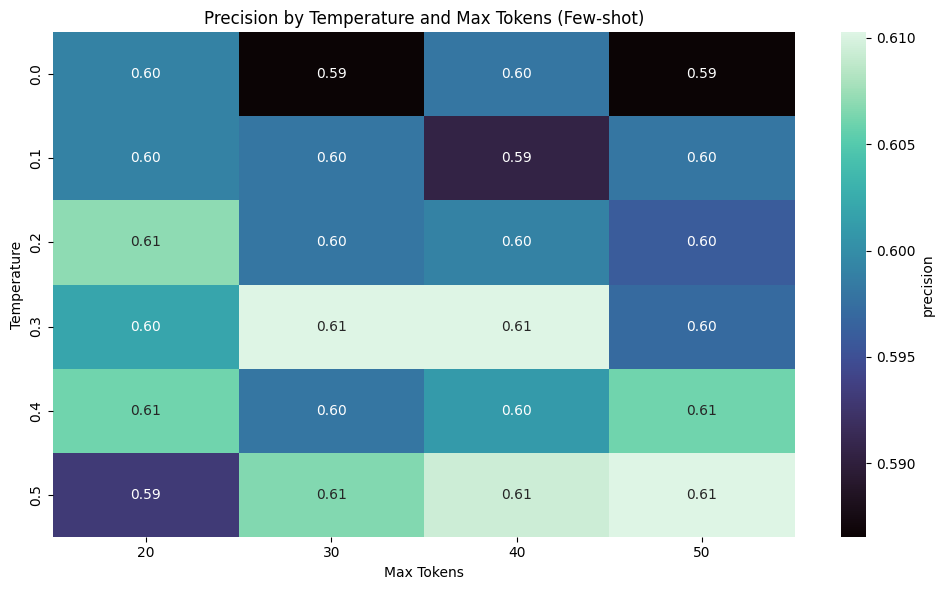

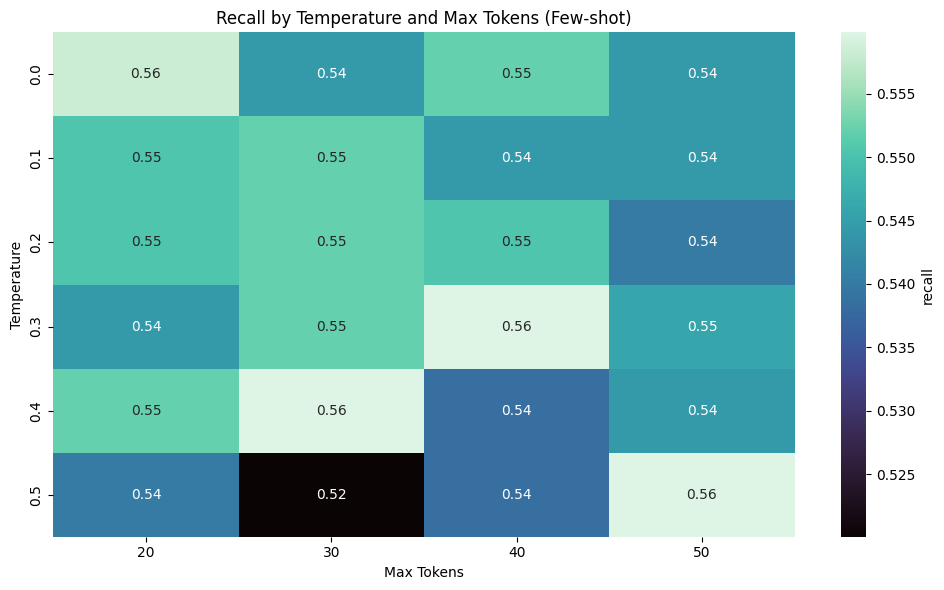

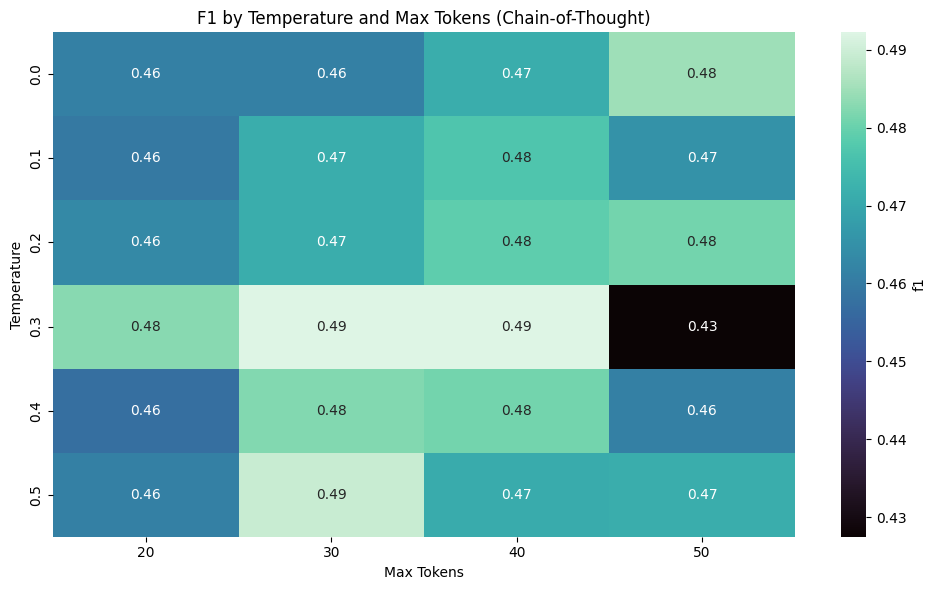

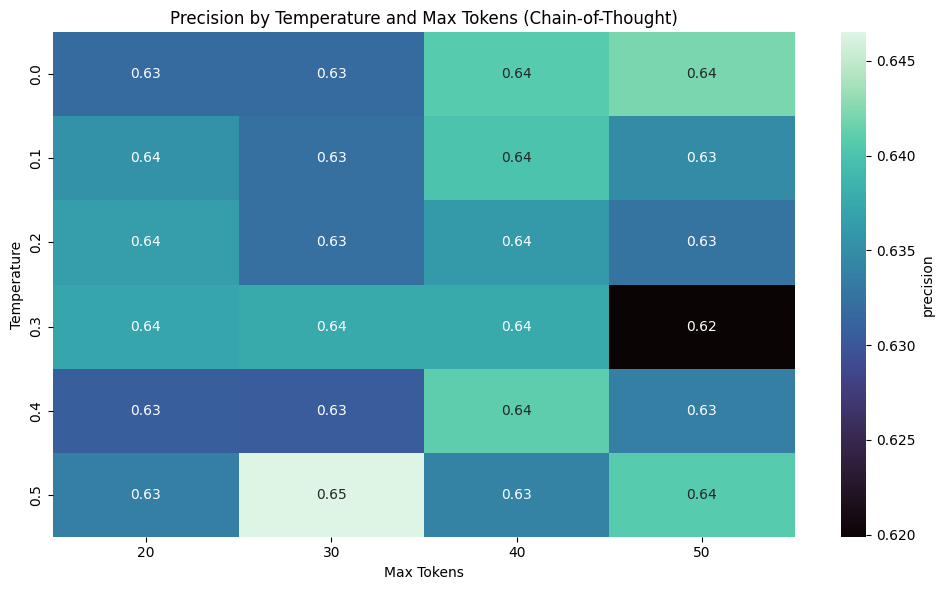

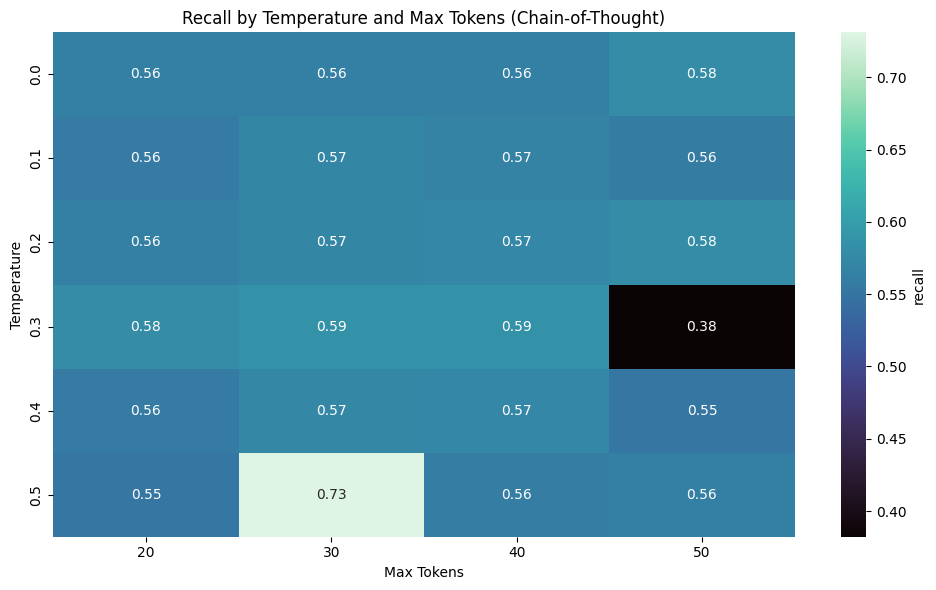

In [31]:
fewshot_df = results_df[results_df["style"] == "fewshot"]
cot_df = results_df[results_df["style"] == "cot"]

# Define function to plot heatmap by metric and style
def plot_metric_heatmap(df, style_name, metric):
    pivot = df.pivot_table(
        index="temperature",
        columns="max_tokens",
        values=metric
    )
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap="mako", cbar_kws={'label': metric})
    plt.title(f"{metric.capitalize()} by Temperature and Max Tokens ({style_name})")
    plt.ylabel("Temperature")
    plt.xlabel("Max Tokens")
    plt.tight_layout()
    plt.show()

# Generate plots for each style and each metric
for style_df, style_name in [(fewshot_df, "Few-shot"), (cot_df, "Chain-of-Thought")]:
    for metric in ["f1", "precision", "recall"]:
        plot_metric_heatmap(style_df, style_name, metric)